In [1]:
#シミュレーション可視化のための３Dアニメーション作成スクリプト
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm

In [50]:
#3D計算＋透視変換用関数ライブラリ

#回転座標変換（機体->地球）
def rot(euler,p):
    phi=euler[0]
    theta=euler[1]
    psi=euler[2]
    x1=p[0]
    y1=p[1]
    z1=p[2]
    
    e11= np.cos(theta)*np.cos(psi)
    e12= np.cos(theta)*np.sin(psi)
    e13=-np.sin(theta)
    
    e21= np.sin(phi)*np.sin(theta)*np.cos(psi) - np.cos(phi)*np.sin(psi)
    e22= np.sin(phi)*np.sin(theta)*np.sin(psi) + np.cos(phi)*np.cos(psi)
    e23= np.sin(phi)*np.cos(theta)
    
    e31= np.cos(phi)*np.sin(theta)*np.cos(psi) + np.sin(phi)*np.sin(psi)
    e32= np.cos(phi)*np.sin(theta)*np.sin(psi) - np.sin(phi)*np.cos(psi)
    e33= np.cos(phi)*np.cos(theta)
    
    x2=e11*x1 + e12*y1 + e13*z1
    y2=e21*x1 + e22*y1 + e23*z1
    z2=e31*x1 + e32*y1 + e33*z1
    
    
    return (x2,y2,z2)

#回転座標変換（地球->機体）
def invrot(euler, p):
    phi=euler[0]
    theta=euler[1]
    psi=euler[2]
    x1=p[0]
    y1=p[1]
    z1=p[2]
    
    e11= np.cos(theta)*np.cos(psi)
    e12= np.cos(theta)*np.sin(psi)
    e13=-np.sin(theta)
    
    e21= np.sin(phi)*np.sin(theta)*np.cos(psi) - np.cos(phi)*np.sin(psi)
    e22= np.sin(phi)*np.sin(theta)*np.sin(psi) + np.cos(phi)*np.cos(psi)
    e23= np.sin(phi)*np.cos(theta)
    
    e31= np.cos(phi)*np.sin(theta)*np.cos(psi) + np.sin(phi)*np.sin(psi)
    e32= np.cos(phi)*np.sin(theta)*np.sin(psi) - np.sin(phi)*np.cos(psi)
    e33= np.cos(phi)*np.cos(theta)
    
    x2=e11*x1 + e21*y1 + e31*z1
    y2=e12*x1 + e22*y1 + e32*z1
    z2=e13*x1 + e23*y1 + e33*z1
    
    
    return [x2,y2,z2]

#平行移動
def tr(mv, p):
    x1=p[0]
    y1=p[1]
    z1=p[2]
    dx=mv[0]
    dy=mv[1]
    dz=mv[2]
    
    x2=x1+dx
    y2=y1+dy
    z2=z1+dz
    
    return [x2, y2, z2]


#平行移動＋回転移動
def move_obj(obj, move , angle):
    _obj=[]
    for part in obj:
        #print(part,'*')
        #part=list(part)
        _part=invrot(angle, part)
        _part=tr(move, _part)
        _part.append(part[-1])
        _obj.append(_part)
    return _obj,len(_obj)

#透視変換＋カメラ座標への座標変換
def perspective(obj, f):
    _obj=[]
    for part in obj:
        #part=list(part)
        x1=part[0]
        y1=part[1]
        z1=part[2]
        
        #暫定版カメラ座標系に座標変換
        xc=y1
        yc=z1
        zc=x1
    
        u= -f*xc/zc
        v=  f*yc/zc
        _obj.append((u,v,x1,part[-1]))
    
    return _obj

#objaの方が近いか近くないかの判断
def judge_near(obja, objb):
    ax=0
    za=obja[ax]
    zb=objb[ax]
    zamin=min(za)
    zbmin=min(zb)
    if zamin<zbmin:
        return True #objaの方が近い
    else:
        return False #objbの方が遠い

#物体リストを遠いものが頭にくる様に並び替える（バブルソート）
def sort_obj(obj):
    _obj=list(obj)
    N=len(_obj)
    for j in range(N-2,0,-1):
        for  i in range(j):
            if judge_near(_obj[i],_obj[i+1]):
                dummy=_obj[i]
                _obj[i]=_obj[i+1]
                _obj[i+1]=dummy
    return _obj 


#物体の２D画面への描画    
def draw_obj(obj, move, angle, f,axis):
    _obj,n = move_obj(obj, move , angle)
    _obj=sort_obj(_obj)
    copter_2d=perspective(_obj, f)
    for part in copter_2d:
        x=part[0]
        y=part[1]
        #z=part[2]
        c=part[3]
        #if(z>f):
        axis.plot(x,y,color=c, lw=2)

def photo(obj,f,axis):
    _obj=sort_obj(obj)
    obj_2d=perspective(_obj, f)
    for part in obj_2d:
        #print(part)
        x=part[0]
        y=part[1]
        z=part[2]
        c=part[3]
        if min(z)>0:
            line=axis.plot(x,y,color=c, lw=1)

def append_obj(a,b):
    a=list(a)
    for p in b:
        a.append(p)
    return a

In [3]:
#マルチコプタ３Dデータ

#座標系（右手系）
# X軸　前
# Y軸　左
# Z軸　上

prop_r=25.4*6/1000/2
copter_L=0.18
frame_l=copter_L*np.sqrt(2)+0.03
frame_l_hf=frame_l/2
frame_w=0.03
frame_w_hf=frame_w/2
prop_loc_z=0.02

#フレームのデータ
_frame_x=np.array([ frame_l_hf, frame_w_hf, frame_w_hf,\
                  -frame_w_hf,-frame_w_hf,-frame_l_hf,\
                  -frame_l_hf,-frame_w_hf,-frame_w_hf,\
                   frame_w_hf, frame_w_hf, frame_l_hf,\
                   frame_l_hf])

_frame_y=np.array([ frame_w_hf, frame_w_hf, frame_l_hf,\
                   frame_l_hf, frame_w_hf, frame_w_hf,\
                  -frame_w_hf,-frame_w_hf,-frame_l_hf,\
                  -frame_l_hf,-frame_w_hf,-frame_w_hf,\
                   frame_w_hf])
frame_x=_frame_x*np.cos(-np.pi/4)-_frame_y*np.sin(-np.pi/4)
frame_y=_frame_x*np.sin(-np.pi/4)+_frame_y*np.cos(-np.pi/4)
frame_z=np.zeros(len(frame_x))

#プロペラのデータ
N=32
th=np.linspace(0, 2*np.pi, N)
prop_x=prop_r*np.cos(th)
prop_y=prop_r*np.sin(th)
prop_z=np.zeros(N)

#各プロペラごとのデータ
prop_fr_x=prop_x+copter_L/2
prop_fr_y=prop_y-copter_L/2
prop_fr_z=prop_z+prop_loc_z

prop_fl_x=prop_x+copter_L/2
prop_fl_y=prop_y+copter_L/2
prop_fl_z=prop_z+prop_loc_z

prop_rr_x=prop_x-copter_L/2
prop_rr_y=prop_y-copter_L/2
prop_rr_z=prop_z+prop_loc_z

prop_rl_x=prop_x-copter_L/2
prop_rl_y=prop_y+copter_L/2
prop_rl_z=prop_z+prop_loc_z

#マルチコプタ全体（
#パーツ(ポリゴン)ごとの物体リスト
copter1=((frame_x, frame_y, frame_z, 'c'),\
        (prop_fr_x, prop_fr_y, prop_fr_z, 'b'),\
        (prop_fl_x, prop_fl_y, prop_fl_z, 'b'),\
        (prop_rr_x, prop_rr_y, prop_rr_z, 'r'),\
        (prop_rl_x, prop_rl_y, prop_rl_z, 'r') )

sankaku1_x=np.array([0,0,0,0])
sankaku1_y=np.array([-0.1,0,0.1,-0.1])
sankaku1_z=np.array([0,0.2,0,0])

sankaku2_x=np.array([0.0,0.0,0.2,0.0])
sankaku2_y=np.array([0.1,0.0,0.0,0.1])
sankaku2_z=np.array([0.0,0.2,0.1,0.0])

sankaku3_x=np.array([0.0,0.0,0.2,0.0])
sankaku3_y=np.array([-0.1,0.0,0.0,-0.1])
sankaku3_z=np.array([0.0,0.2,0.1,0.0])


copter2=((sankaku1_x,sankaku1_y,sankaku1_z,'g'),\
         (sankaku2_x,sankaku2_y,sankaku2_z,'r'),\
         (sankaku3_x,sankaku3_y,sankaku3_z,'b'))\


copter=copter1



In [4]:
#ゲートデータ
N=6
length=0.25
wide=0.1
th=np.linspace(0, 2*np.pi, N+1)
gatein_x=np.zeros(N+1)
gatein_y=length*np.cos(th)
gatein_z=length*np.sin(th)

gateout_x=np.zeros(N+1)
gateout_y=(length+wide)*np.cos(th)
gateout_z=(length+wide)*np.sin(th)

gate=[]

for index in range(6):
    part=[]
    part.append(np.array((gatein_x[0+index],gatein_x[1+index],gateout_x[1+index],gateout_x[0+index],gatein_x[0+index])))
    part.append(np.array((gatein_y[0+index],gatein_y[1+index],gateout_y[1+index],gateout_y[0+index],gatein_y[0+index])))
    part.append(np.array((gatein_z[0+index],gatein_z[1+index],gateout_z[1+index],gateout_z[0+index],gatein_z[0+index])))
    part.append('g')
    gate.append(part)

_gate1,n=move_obj(gate,(2,0,0),(0,0,0))
_gate2,n=move_obj(gate,(2+np.sqrt(2),-2+np.sqrt(2),0),(0,0,-45*np.pi/180))
stage=append_obj(_gate1, _gate2)


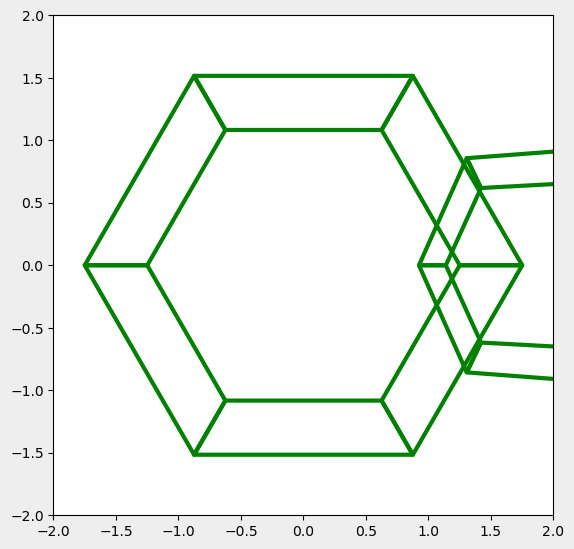

In [5]:
fig=plt.figure(figsize=(5,5),facecolor='#EEEEEE',dpi=100)
ax=fig.add_subplot()
ax.set_position([0, 0, 1, 1])
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
photo(stage, 10, ax)
plt.show()
plt.close()

In [221]:
#アニメーション作成関数ライブラリ(新)

def draw_animation_frame(obj, f, index):
    fig=plt.figure(figsize=(19.20,10.80),facecolor='#EEEEEE',dpi=100)
    ax=fig.add_subplot()
    ax.set_position([0, 0, 1, 1])
    ax.axis("off")
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2*1080/1920, 2*1080/1920)

    photo(obj, f, ax)

    plt.savefig('drl_img/anim_frame{:04d}'.format(index))
    #plt.show()
    plt.close()
    

def make_animation(copter, stage, move, angles, index0):
    index=index0;
    for phi,theta,psi,x,y,z in tqdm(\
                    zip(angles[0], angles[1], angles[2],move[0],move[1],move[2]),\
                    total=len(angles[0])):
        angle=(phi,theta,psi)
        move=(x,y,z)
        f=5
        _copter,n=move_obj(copter, move, angle)
        obj=append_obj(_copter,stage)
            
        draw_animation_frame(obj, f, index)

        index=index+1
    return index


In [233]:
#メイン（新）
#動き生成してアニメ作成関数を呼ぶ

fintime=1.5
fps=24
N=int(fintime*fps)
zpos=0.1
ypos=0
phia=0.02
theta0=10*np.pi/180
omega=80

t=np.linspace(0,fintime,N)
zeros=np.zeros(N)
x1=np.linspace(0,2,N)
y1=zeros+ypos
z1=zeros+zpos
phi1=phia*np.sin(omega*t/fintime)
th1=zeros+theta0
psi1=zeros

x2= 2+2*np.cos(np.pi/2-np.pi*t/fintime/2)
y2=-2+2*np.sin(np.pi/2-np.pi*t/fintime/2)+ypos
z2=zeros+zpos
phi2=phia*np.sin(omega*t/fintime+omega)
th2=zeros+theta0
psi2=-np.pi*t/fintime/2

_stage,n=move_obj(stage, (0, 0, zpos), (0, 0, 0))

index=0
index=make_animation(copter, _stage, (x1, y1, z1),(phi1,th1,psi1), index)
index=make_animation(copter, _stage, (x2, y2, z2),(phi2,th2,psi2), index)


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

In [234]:
#ffmpegを使い　MP4ファイル生成
import os
import ffmpeg as fp

filename='drl_animation.mp4'

try:
    os.remove(filename)
except:
    print('Not found {:s}'.format(filename))
stream = fp.input('drl_img/anim_frame%04d.png')
stream = fp.output(stream, filename,\
                   r=24,\
                   vcodec='libx264',\
                   pix_fmt='yuv420p',\
                   loglevel='quiet')
r=fp.run(stream)
print('Finish to create MP4 file. ')

Finish to create MP4 file. 


In [8]:
#アニメーション作成関数ライブラリ(新)

def draw_animation_frame(obj, f, index):
    fig=plt.figure(figsize=(19.20,10.80),facecolor='#EEEEEE',dpi=100)
    ax=fig.add_subplot()
    ax.set_position([0, 0, 1, 1])
    ax.axis("off")
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2*1080/1920, 2*1080/1920)

    photo(obj, f, ax)

    plt.savefig('drone_show/anim_frame{:04d}'.format(index))
    #plt.show()
    plt.close()
    

def make_animation(copter, stage, move, angles, index0):
    index=index0;
    for phi,theta,psi,x,y,z in tqdm(\
                    zip(angles[0], angles[1], angles[2],move[0],move[1],move[2]),\
                    total=len(angles[0])):
        angle=(phi,theta,psi)
        move=(x,y,z)
        f=5
        _copter,n=move_obj(copter, move, angle)
        obj=append_obj(_copter,stage)
            
        draw_animation_frame(obj, f, index)

        index=index+1
    return index


In [60]:
#メイン ドローンショー
#動き生成してアニメ作成関数を呼ぶ

Num=100
MOVES=[]
ANGLES=[]

fintime=5
fps=24
FN=int(fintime*fps)
R=3.0
rate=0.01

dth=2*np.pi/FN

height=10
omega=2
f=3          

for fn in tqdm(range(FN)):
    moves=[]
    angles=[]
    R=R
    obj=[]
    counter=0
    for phi in np.linspace(0,2*np.pi,50):
        num=int(2*np.pi*(R*np.sin(phi))/1)
        for n in range(num):
            counter+=1
            psi=n*2*np.pi/num+fn*dth
            x=height+R*np.sin(phi)*np.sin(psi)
            y=R*np.sin(phi)*np.cos(psi)
            z=R*np.cos(phi)
            move=(x,y,z)
            angle=(phi, 0, psi)

            #print(move)
            _copter,n=move_obj(copter, move, angle)
            obj=append_obj(obj,_copter)
    draw_animation_frame(obj, f, fn)
print('Finish copter=',counter)

  0%|          | 0/120 [00:00<?, ?it/s]

Finish copter= 283


In [61]:
#ffmpegを使い　MP4ファイル生成
import os
import ffmpeg as fp

filename='droneshow283.mp4'

try:
    os.remove(filename)
except:
    print('Not found {:s}'.format(filename))
stream = fp.input('drone_show/anim_frame%04d.png')
stream = fp.output(stream, filename,\
                   r=24,\
                   vcodec='libx264',\
                   pix_fmt='yuv420p',\
                   loglevel='quiet')
r=fp.run(stream)
print('Finish to create MP4 file. ')

Not found droneshow283.mp4
Finish to create MP4 file. 
